In [1]:
import keras
import numpy as np
import pretty_midi
import librosa
import glob
import os
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from train_util import NoteIsoSequence
from model import get_autoencoder, get_vae, get_gan
from train_util import program_map, one_hot_map
from keras import backend as K
import time
import sklearn
from hparams import *

# synthesize without label and then add back for train?
# loud not at the end to force normalization?

Using TensorFlow backend.


In [2]:
wav_file = wav_files[0]
print(wav_file)
midi_file = wav_file[:-4] + ".mid"
pm = pretty_midi.PrettyMIDI(midi_file)
pm_samples = pm.fluidsynth(fs=sample_rate, sf2_path=sf2_path)

/home/faraaz/workspace/music-transcription/data/clean_midi/Redbone/Come and Get Your Love.wav


In [23]:
instr_indices = [0, 1]
note_indices = [0, 50]
song_indices = [0, 0]
test_generator = NoteIsoSequence([wav_file], sample_duration=sample_duration, 
                                 sample_rate=sample_rate, n_fft=n_fft, instr_indices=instr_indices,
                                 note_indices=note_indices, song_indices=song_indices, batch_size=1)

In [5]:
padded_samples = test_generator.pad_samples(pm_samples, sample_start)
print(padded_samples.shape)
print(padded_samples[-1])
ipd.Audio(padded_samples, rate=sample_rate)

(32000,)
0.05545407098121086


(-0.007802645+0j)


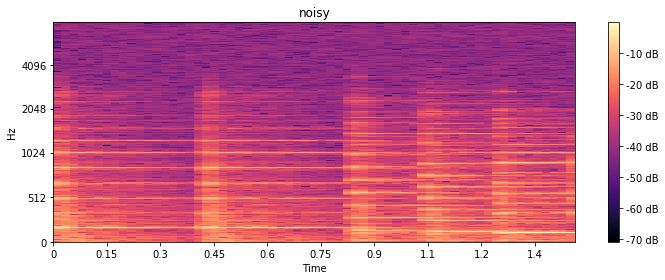

In [6]:
noisy_stft = librosa.core.stft(y=padded_samples, n_fft=n_fft)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(noisy_stft), ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('noisy')
plt.tight_layout()
print(noisy_stft[-1][-1])

/home/faraaz/anaconda3/envs/urop/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


(1024, 63, 2)
[-0.79820912  0.00409422]


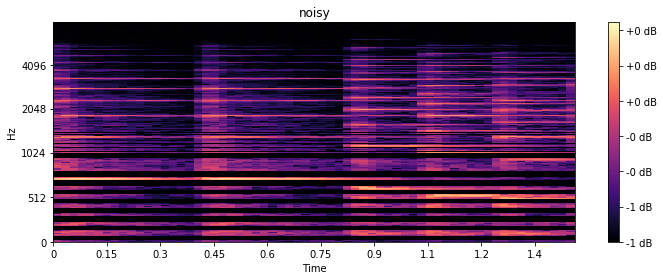

In [7]:
noisy_stft, mag_scale, phase_scale = test_generator.hp_scale(noisy_stft)
print(noisy_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(noisy_stft[:,:,0], y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('noisy')
plt.tight_layout()
print(noisy_stft[-1][-1])

In [8]:
og_noisy_stft = test_generator.if_mel_hp_unscale(noisy_stft, mag_scale, phase_scale)
noisy_audio = librosa.core.istft(og_noisy_stft)
ipd.Audio(noisy_audio, rate=sample_rate)

In [9]:
velocity = 96
pitch = 60
duration = 1
pm_iso = pretty_midi.PrettyMIDI()
iso_instrument = pretty_midi.Instrument(instrument.program, is_drum=False)
iso_note = pretty_midi.Note(velocity, note.pitch, 0, duration)
iso_instrument.notes = [iso_note]
pm_iso.instruments = [iso_instrument]

pm_iso_samples = pm_iso.fluidsynth(fs=sample_rate, sf2_path=sf2_path)
pm_iso_samples = test_generator.pad_samples(pm_iso_samples, 0)
ipd.Audio(pm_iso_samples, rate=sample_rate)

(1025, 63)


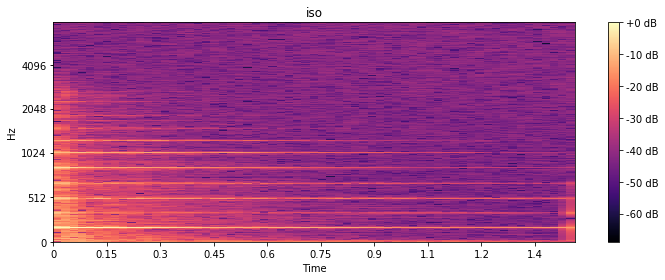

In [10]:
iso_stft = librosa.core.stft(y=pm_iso_samples, n_fft=n_fft)
print(iso_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(iso_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('iso')
plt.tight_layout()

/home/faraaz/anaconda3/envs/urop/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


(1024, 63, 2)
[-0.79820912  0.00409422]


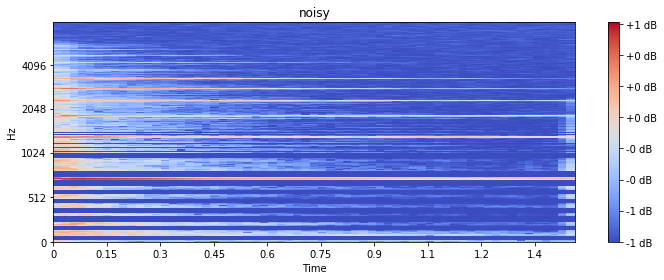

In [11]:
iso_stft, iso_mag_scale, iso_phase_scale = test_generator.if_mel_hp_scale(iso_stft)
print(iso_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(iso_stft[:,:,0], y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('noisy')
plt.tight_layout()
print(noisy_stft[-1][-1])

In [12]:
og_iso_stft = test_generator.if_mel_hp_unscale(iso_stft, iso_mag_scale, iso_phase_scale)
iso_audio = librosa.core.istft(og_iso_stft)
ipd.Audio(iso_audio, rate=sample_rate)

In [13]:
print("loading model")
model_type = 'ae+'

if model_type == 'ae':
    encoder = keras.models.load_model("ae/encoder-test.h")
    decoder = keras.models.load_model("ae/decoder-test.h")
    _, _, autoencoder = get_autoencoder(encoder, decoder)
if model_type == 'ae+':
    encoder = keras.models.load_model("ae/encoder-test.h")
#     decoder = keras.models.load_model("ae/decoder-test.h")
#     _, _, autoencoder = get_autoencoder(encoder, decoder)
elif model_type == 'vae':
    encoder = keras.models.load_model("vae/encoder-1.h")
    decoder = keras.models.load_model("vae/decoder-1.h")
    encoder, decoder, autoencoder, _ = get_vae(encoder, decoder)
#     autoencoder = keras.models.load_model('vae/vae-0.h', custom_objects={'my_vae_loss': my_vae_loss})
elif model_type == 'gan':
    autoencoder = keras.models.load_model('gan/ae-0.h')
else:
    assert False

loading model


/home/faraaz/anaconda3/envs/urop/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [17]:
predicted_encode = encoder.predict_generator(test_generator)#[0]
print(len(predicted_encode))
print(predicted_encode.shape)
# predicted_decode = decoder.predict(predicted_encode)
# print(predicted_decode.shape)
# predicted_ae = autoencoder.predict_generator(test_generator)
# print(predicted_ae.shape)
# print(np.all(predicted_decode == predicted_ae))

3
(3, 64)


In [15]:
instr_id = 1
predicted_iso = predicted_ae[instr_id]

print("predicted_iso min {}, predicted_iso max {}".format(np.amin(predicted_iso), np.amax(predicted_iso)))
print("predicted_iso nans {}".format(np.count_nonzero(np.isnan(predicted_iso))))
# print(np.count_nonzero(np.abs(predicted_iso[:,:,1]) == 1))
predicted_stft = test_generator.if_mel_hp_unscale(predicted_iso, iso_mag_scale, iso_phase_scale)
print("{}. {}".format(instr_id, pm.instruments[instr_id]))
print("predicted_stft {}".format(predicted_stft.shape))
print("predicted_stft min {}, predicted_stft max {}".format(np.amin(predicted_iso), np.amax(predicted_iso)))
print("predicted_stft nans {}".format(np.count_nonzero(np.isnan(predicted_stft))))
# print(np.count_nonzero(np.abs(predicted_stft[:,:,1]) == 1))

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(predicted_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('predicted')
plt.tight_layout()

NameError: name 'predicted_ae' is not defined

In [18]:
predicted_audio = librosa.core.istft(predicted_stft)
ipd.Audio(predicted_audio, rate=sample_rate)

NameError: name 'predicted_stft' is not defined

In [19]:
# instr_indices = list(range(3))*50 #[]
# note_indices = list(range(50))*3 #[]
# song_indices = [0]*150 #[]
# instr_indices = [] #[0, 1, 2] * 10
# note_indices = [] #list(range(3)) * 10#[0, 50, 100]
# song_indices = [] #[0, 0, 0] * 10
# test_generator = NoteIsoSequence(test_wav_files, sample_duration=sample_duration, 
#                                  sample_rate=sample_rate, n_fft=n_fft, instr_indices=instr_indices,
#                                  note_indices=note_indices, song_indices=song_indices, batch_size=1)

mid_file = test_wav_files[0][:-4] + ".mid"
pm = pretty_midi.PrettyMIDI(mid_file)
num_instruments = len(pm.instruments)
print(num_instruments)
kmeans = sklearn.cluster.KMeans(n_clusters=num_instruments)
embeddings = encoder.predict_generator(test_generator)
print(embeddings.shape)

2
(3, 64)


In [24]:
embed_clusters = kmeans.fit_predict(embeddings)
cluster_dict = {}
for i in range(len(instr_indices)):
    instr_id = instr_indices[i]
    cluster_id = embed_clusters[i]
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = [0]*num_instruments
    print("instr_id {}".format(instr_id))
    cluster_dict[cluster_id][instr_id] += 1

for cluster_id in range(num_instruments):
    print("{}. {}".format(cluster_id, cluster_dict[cluster_id]))
    

instr_id 0
instr_id 1
0. [0, 1]
1. [1, 0]


In [21]:
print(embeddings[0])
print(embeddings[1])

[ 2.01713371e+01  3.34006577e+01  1.71118679e+01 -2.11854815e+00
 -1.05466814e+01  4.05104256e+00  8.08386707e+00 -5.87095499e+00
 -1.15519657e+01 -2.05817356e+01 -5.07786560e+00 -2.70803070e+00
 -8.04435444e+00  6.38222647e+00  1.03779526e+01 -2.31522036e+00
 -9.07476139e+00 -1.67555809e+01 -7.59811497e+00 -1.64221458e+01
  1.61732635e+01 -5.59876680e+00 -1.28780975e+01  1.26618147e+01
 -2.36561894e-03  1.49199886e+01 -1.20980196e+01  3.12430038e+01
 -3.62942719e+00 -1.26279411e+01  8.78502131e-01  1.13929052e+01
 -6.79871380e-01  1.15054121e+01  1.69450235e+00 -4.08974111e-01
 -1.06626663e+01 -8.67547035e+00  8.96808529e+00 -1.10705137e+01
 -3.49471245e+01  1.30823267e+00 -2.05480709e+01 -2.97740383e+01
 -1.09213610e+01 -6.69720459e+00  2.27418327e+01 -1.58978395e+01
 -2.03546524e+01 -7.54686165e+00 -1.95864925e+01  1.02303095e+01
  1.23232059e+01  1.71605682e+01 -7.61431456e+00  2.06267948e+01
  1.38598289e+01 -3.91086693e+01  1.09398489e+01  7.22252011e-01
  1.21882219e+01 -1.75367